-------

# K-Nearest Neighbours

The purpose of this notebook is to use the K-nearest neighbours model type to demonstrate how overfitting can occur. This model type is very easy to understand and is therefore a good candidate for demonstrating overfitting.

The structure is as follows:

1. Create a synthetic dataset where each data point has two variable values and is assigned to a particular class. There is a decision boundary in place and we use a conditional prpbability distribution to influence which class each data point will belong to.
2. We train a few differnet KNN models, each with a different value of k and assess the error rate. We use plots to demonstrate how a more flexible model can overfit, whilst an inflexible model can underfit

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

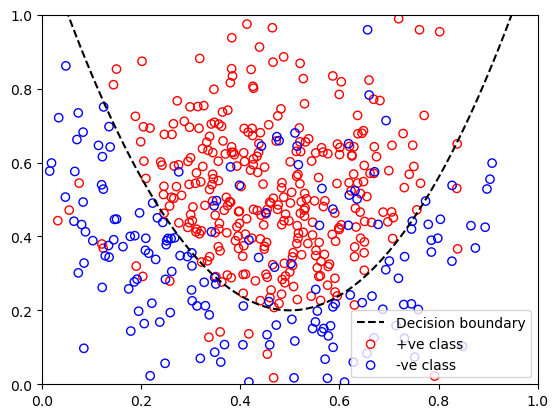

In [2]:
n_samples = 500
use_normal = True  # whether to use the normal distribution to get sample data. If False, use a uniform dist


def decision_boundary(x):
    return 4*(x - 0.5)**2 + 0.2


def determine_class_prob(x1, x2):
    y = decision_boundary(x1)

    if y > x2:
        return 0.1
    else:
        return 0.9


# generate the decision boundary as a continous line for plotting
x1 = np.linspace(0, 1, 101)
x2 = decision_boundary(x1)

# generate some synthetic data points and make sure they fall within the range [0, 1]
np.random.seed(n_samples)

if use_normal:
    data = np.random.normal(0.45, 0.2, size=(n_samples, 2))
else:
    data = np.random.rand(n_samples, 2)

data = data[
    (data[:, 0] >= 0)
    & (data[:, 0] <= 1)
    & (data[:, 1] >= 0)
    & (data[:, 1] <= 1)
].copy()

# add a probability of belonging to the +ve class for each sample
data = np.column_stack(
    [data, [determine_class_prob(x[0], x[1]) for x in data]]
)

# use Bernoulli trial to get the class
data = np.column_stack(
    [data, np.random.binomial(1, p=data[:, 2], size=data.shape[0])]
)

# ---- Plot the samples alongside the decision boundary
fig, ax = plt.subplots()

# decision boundary
ax.plot(x1, x2, label="Decision boundary", linestyle="--", color="k")

# random samples
# +ve class
ax.scatter(
    data[data[:, 3] == 1, 0],
    data[data[:, 3] == 1, 1],
    facecolors="None",
    edgecolors="r",
    label="+ve class",
)
# -ve class
ax.scatter(
    data[data[:, 3] == 0, 0],
    data[data[:, 3] == 0, 1],
    facecolors="None",
    edgecolors="b",
    label="-ve class",
)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.legend()

In [3]:
# we will still make predictions for every sample but we create a test set
# so that we can have some sort of measurable error rate
train, test = train_test_split(data, test_size=0.3)
train.shape, test.shape

((341, 4), (147, 4))

    K  ErrorRate
0   1   0.204082
1   5   0.149660
2  10   0.108844
3  50   0.272109


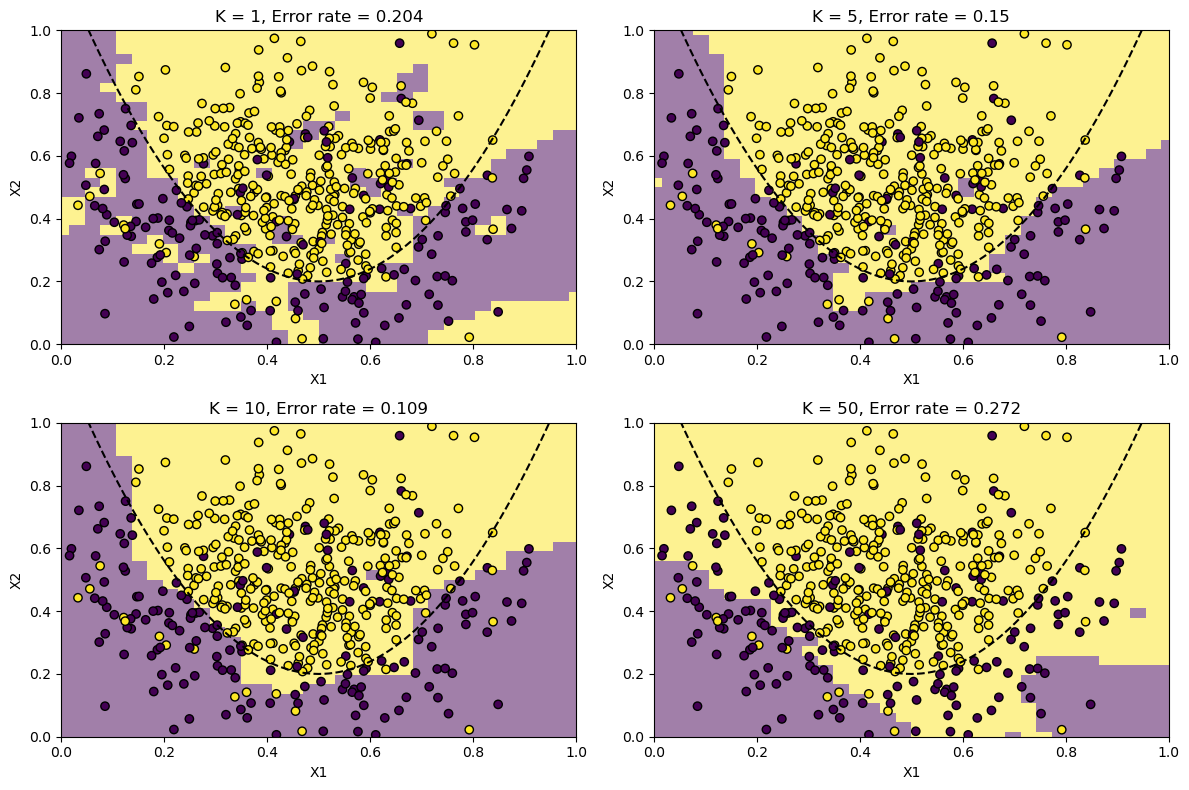

In [4]:
def error_rate(target, pred):
    return (target != pred).mean()


k_options = [1, 5, 10, 50]
fig, axes = plt.subplots(
    ncols=2,
    nrows=len(k_options) // 2,
    figsize=(12, 4 * len(k_options) / 2)
)

error_list = []
for ii, k in enumerate(k_options):
    row = ii // 2
    col = ii % 2
    
    ax = axes[row, col]

    # fit the model
    model_knn = KNeighborsClassifier(k)
    model_knn.fit(
        train[:, :2],
        train[:, -1]
    )

    # get the error rate
    error_list += [
        error_rate(test[:, -1], model_knn.predict(test[:, :2]))
    ]

    # plot the decision boundary using some sklearn wizardry
    disp = DecisionBoundaryDisplay.from_estimator(
        model_knn,
        np.array([(x, y) for x in x1 for y in x1]),
        response_method="predict",
        plot_method="pcolormesh",
        alpha=0.5,
        ax=ax
    )

    # plot the samples
    disp.ax_.scatter(
        data[:, 0],
        data[:, 1],
        c=data[:, -1],
        edgecolor="k",
    )

    # the decision boundary
    disp.ax_.plot(x1, x2, color="k", linestyle="--")

    # -------- formatting
    disp.ax_.set_xlim(0, 1)
    disp.ax_.set_ylim(0, 1)

    disp.ax_.set_xlabel("X1")
    disp.ax_.set_ylabel("X2")
    disp.ax_.set_title(f"K = {k}, Error rate = {np.round(error_list[ii], 3)}")

df_error = pd.DataFrame({"K": k_options, "ErrorRate": error_list})
print(df_error)

fig.tight_layout()
plt.show()

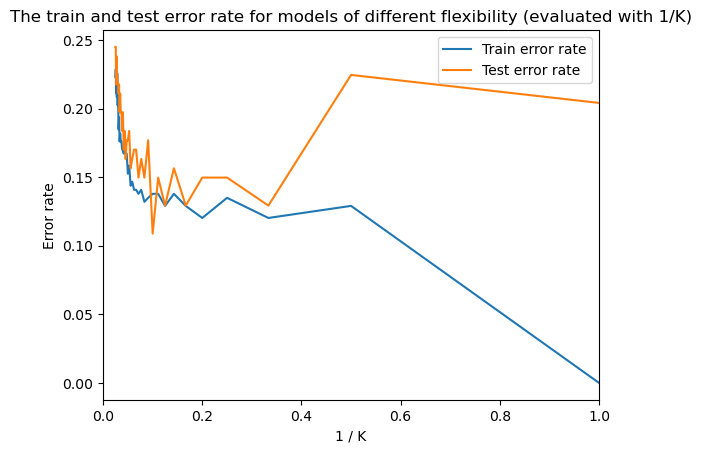

In [5]:
k_options = list(range(1, 41))
error_list_train = []
error_list_test = []
for ii, k in enumerate(k_options):
    # fit the model
    model_knn = KNeighborsClassifier(k)
    model_knn.fit(
        train[:, :2],
        train[:, -1]
    )

    # get the error rate
    error_list_train += [
        error_rate(train[:, -1], model_knn.predict(train[:, :2]))
    ]
    
    error_list_test += [
        error_rate(test[:, -1], model_knn.predict(test[:, :2]))
    ]


fig, ax = plt.subplots()
ax.plot(
    [1/k for k in k_options],
    error_list_train,
    label="Train error rate",
)
ax.plot(
    [1/k for k in k_options],
    error_list_test,
    label="Test error rate",
)

ax.set_xlim(0, 1)

ax.set_xlabel("1 / K")
ax.set_ylabel("Error rate")
ax.set_title("The train and test error rate for models of different flexibility (evaluated with 1/K)")
ax.legend()